# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import os
from IPython.display import Image
import joblib

from sklearn.metrics import  roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression, LassoCV , LassoLarsCV, RidgeCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

##Read data

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12//test.csv')
submission = pd.read_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12/sample_submission.csv')
print(df_train.shape)
print(df_test.shape)
print(submission.shape)
print('-'*100)
X = df_train.drop(['id','target'], axis=1)
y = df_train['target']
test = df_test.drop(['id'], axis=1)
#stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(test.shape)

(250, 302)
(19750, 301)
(19750, 2)
----------------------------------------------------------------------------------------------------
(240, 300) (240,)
(10, 300) (10,)
(19750, 300)


# Scaling data

In [3]:
def scale(X_train, X_test, test):
    '''
    Normalize the input varaible

    X_train: train variable
    X_test: test variable
    test: Submission test Variable

    Return:
    Scaled/Normalized values of each varaibles
    '''
    scaler  = StandardScaler()
    X_train  = scaler.fit_transform(X_train)
    test = scaler.transform(test)
    X_test = scaler.transform(X_test)
    return X_train, X_test, test

In [4]:
#since the scoring is based on auc-roc we plot it to check results
#https://towardsdatascience.com/dont-overfit-ii-how-to-avoid-overfitting-in-your-machine-learning-and-deep-learning-models-2ff903f4b36a
# https://medium.com/analytics-vidhya/kaggle-competition-dont-overfit-ii-74cf2d9deed5
def plot_roc(train_true, train_pred, test_true, test_pred, axis, model_name, cv_score, train_acc, test_acc, n_classes=2):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    train_true: train true label
    train_pred: train predict probabilities value
    test_true: Sample Test true label
    test_pred: Sample Test predict probabilities value
    axis: axis of plot
    model_name: Name of Model curve
    cv_score: CV score of model
    train_acc: Train accuracy of Model
    test_acc: Test accuracy of Model
    n_classes: number of unique classes
    
    Return:
    Nothing   
    '''
    # For train
    tr_fpr = dict()
    tr_tpr = dict()
    tr_roc_auc = dict()
    for i in range(n_classes):
        tr_fpr[i], tr_tpr[i], _ = roc_curve(train_true, train_pred[:, i])
        tr_roc_auc[i] = auc(tr_fpr[i], tr_tpr[i])

    # For Sample Test
    te_fpr = dict()
    te_tpr = dict()
    te_roc_auc = dict()
    for i in range(n_classes):
        te_fpr[i], te_tpr[i], _ = roc_curve(test_true, test_pred[:, i])
        te_roc_auc[i] = auc(te_fpr[i], te_tpr[i])

    # Plot roc for train
    axis.plot(tr_fpr[1], tr_tpr[1], color='red', alpha=0.5, 
            lw=2, label='ROC curve for Train (area = %0.2f)' % tr_roc_auc[1])
    # Plot roc for Sample Test
    axis.plot(te_fpr[1], te_tpr[1], color='green', alpha=0.5, 
            lw=2, label='ROC curve for Sample Test (area = %0.2f)' % te_roc_auc[1])
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(model_name+' Receiver operating characteristic: train vs Sample Test')
    axis.legend(loc="lower right")

    axis.text(x=1.0, y=0.40, transform=axis.transAxes, s="Mean CV ROC_AUC: {:.4f}".format(cv_score),\
            fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='r')
    axis.text(x=1.0, y=0.34, transform=axis.transAxes, s="Train Accuracy: {:.4f}".format(train_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='b')
    axis.text(x=1.0, y=0.28, transform=axis.transAxes, s="Sample Test Accuracy: {:.4f}".format(test_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='g')

In [5]:
def Model():
    '''
    There are total 8 algorithms with list of their hyperparameters
    1. Logistic Regression (linear)
    2. Linear Discriminate Analysis(linear)
    3. K Neighbors Classifiers (non-linear)
    4. Decision Tree (non-linear)
    5. Naive Bayes (non-linear)
    6. Support Vector Classifiers (non-linear)
    7. Random Forest (non-linear)
    8. XGBoost (non-linear)

    Return:
    all the models along with their name, list of hyperparamaters and short_name
    '''
    # Hyperparameters for Logistic Regression
    LRparams = {
        "class_weight":["balanced"],
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4],
        "solver":["liblinear"],
    }
    # Hyperparameters for Linear Discriminate Analysis
    LDAparams = {
        "solver" : ["svd"],
        "tol" : [0.0001,0.0002,0.0003]
    }
    # Hyperparameters for K Neighbors Classifiers
    KNNparams = {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'n_jobs':[-1]
    }
    # Hyperparameters for Decision Tree
    DTparams = {
        "max_depth": [3, 5 , 10, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10,50],
        "criterion": ["gini", "entropy"],
        "class_weight":["balanced"]
    }
    # Hyperparameters for Naive Bayes
    NBparams = {
        'var_smoothing': np.logspace(0,-9, num=100)   
    }
    # Hyperparameters for Support Vector Classifiers
    SVCparams = {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
        'class_weight': ['balanced'],
        'probability': [True]
    }
    # Hyperparameters for Random Forest
    RFparams = {
        'criterion':['gini','entropy'],
        'n_estimators':[10,15,20,25,30],
        'min_samples_leaf':[1,2,3,4,5],
        'min_samples_split':[3,4,5,6,7], 
        'n_jobs':[-1],
        'class_weight' : ["balanced", "balanced_subsample"]
    }
    # Hyperparameters for XGBoost
    XGBparams={
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[10,20,30,40,100],
        'max_depth':[2,3,5,10],
        'colsample_bytree':[0.1,0.3,0.5,1],
        'subsample':[0.1,0.3,0.5,1],
        'n_jobs':[-1],
    }
    # Models
    models = []
    models.append(('Logistic Regression', LogisticRegression(random_state=42), LRparams,'LR'))
    models.append(('Linear Discriminate Analysis', LinearDiscriminantAnalysis(), LDAparams,'LDA'))
    models.append(('K Neighbors Classifiers', KNeighborsClassifier(), KNNparams,'KNN'))
    models.append(('Decision Tree', DecisionTreeClassifier(random_state=42), DTparams,'DT'))
    models.append(('Naive Bayes', GaussianNB(), NBparams,'NB'))
    models.append(('Support Vector Classifiers', SVC(random_state=42), SVCparams,'SVC'))
    models.append(('Random Forest', RandomForestClassifier(random_state=42), RFparams,'RF'))
    models.append(('XGBoost', XGBClassifier(random_state=42), XGBparams,'XGB'))
    return models

In [6]:
def save_test_result(pred, Modeltype, Modelname):

    '''
    Make a dataframe of submission ids and respective predicted probability
    and save into drive

    pred: predictions of model
    Modeltype: type of model
    Modelname: Name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('/content/drive/MyDrive/CasestudiesAAIC/self case study12/result/'+Modeltype):
        os.mkdir('/content/drive/MyDrive/CasestudiesAAIC/self case study12/result/'+Modeltype)

    id = submission['id']
    test_df = pd.DataFrame(np.column_stack((id,pred)), columns=['id','target'])
    test_df['id'] = test_df['id'].astype('int32')
    test_df.to_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12/result/'+Modeltype+'/'+Modeltype+'_'+Modelname+'submit.csv', index=False)


In [7]:
def save_model(model, Modeltype, Modelname):
    '''
    It will save to trained model into drive for use in future
    model: classifiers
    Modeltype: type of model
    Modelname: name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('/content/drive/MyDrive/CasestudiesAAIC/self case study12/SavedModel/'+Modeltype):
        os.mkdir('/content/drive/MyDrive/CasestudiesAAIC/self case study12/SavedModel/'+Modeltype)
        
    filename = '/content/drive/MyDrive/CasestudiesAAIC/self case study12/SavedModel/'+Modeltype+'/'+Modeltype+'_'+Modelname+'model.sav'
    joblib.dump(model, filename)


In [8]:
def trainWithBestModelAndParams(X_train, X_test, y_train, y_test, Modeltype, Test = test, CV=5, Scaling=True):
    '''
    Select Best ML model with their best hyperparamaters
    
    Parameters:
    X_train: train data
    X_test: Sample test data
    y_train: train true label
    y_test: Sample Test true label
    Test: test data for submission
    CV: Number of cross-validation folds
    Scaling: For Scaling of Input varaibles 
    
    Return:
    Best Classifiers   
    '''
    models = Model()
    # Scaling Features
    if Scaling:
        X_train, X_test, Test = scale(X_train, X_test, Test)

    #RandomSearch    
    result = []
    print('{:31}| {:6} | {}'.format('Estimator', 'Score', 'Best Parameters'))
    print('-'*180)
    for name, model, params, abr in models:
        rs=RandomizedSearchCV(model ,param_distributions = params ,verbose=0, n_jobs=-1, scoring='roc_auc',cv = CV, n_iter=10, random_state=42)
        rs.fit(X_train,y_train)
        result.append((name, rs.best_score_, rs.best_params_, rs.best_estimator_, abr))
        print('{:31}| {:.4f} | {}'.format(name, rs.best_score_, rs.best_params_))

    # Selecting Best Score Model
    mx = -1
    best_model = 0
    for i in result:
        if(i[1]>mx):
            mx = i[1]
            best_model = i
    print('_'*180)
    print('{:15}:{}'.format('Best Model', best_model[0]))
    print('{:15}:{:.4}'.format('CV Score', best_model[1]))
    print('{:15}:{}'.format('Parameters', best_model[2]))
    print('{:15}:{}'.format('Estimator', best_model[3]))
    print('_'*180)
    
    #Training Models
    print('Training Models..')
    sns.set(rc={'figure.figsize':(30,30)})
    fig, ax = plt.subplots(4, 2,sharex='col', sharey='row')
    ax = ax.reshape(-1)

    classifiers = []
    for i, model in enumerate(result):
        clf = model[3]
        clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
        clf.fit(X_train,y_train)

        #Save Model into disk
        save_model(clf, Modeltype, model[4])

        #Append classifier into list
        classifiers.append((model[0], clf))

        #Predicting
        #pred = clf.predict(Test)
        pred = clf.predict_proba(Test)[:,1]

        #Saving prediction into disk
        save_test_result(pred, Modeltype, model[4])

        #Plotting ROC AUC
        plot_roc(y_train, clf.predict_proba(X_train), y_test, clf.predict_proba(X_test),\
                 ax[i], model[0], model[1], clf.score(X_train,y_train), clf.score(X_test, y_test), n_classes=2)

        print(model[0]+' done.')
    print('_'*180)
    print('Plotting ROC curve')
    plt.show()
    classifiers = dict(classifiers)
    return best_model, classifiers


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7937 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.7165 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6088 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.6387 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7586 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7621 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest       

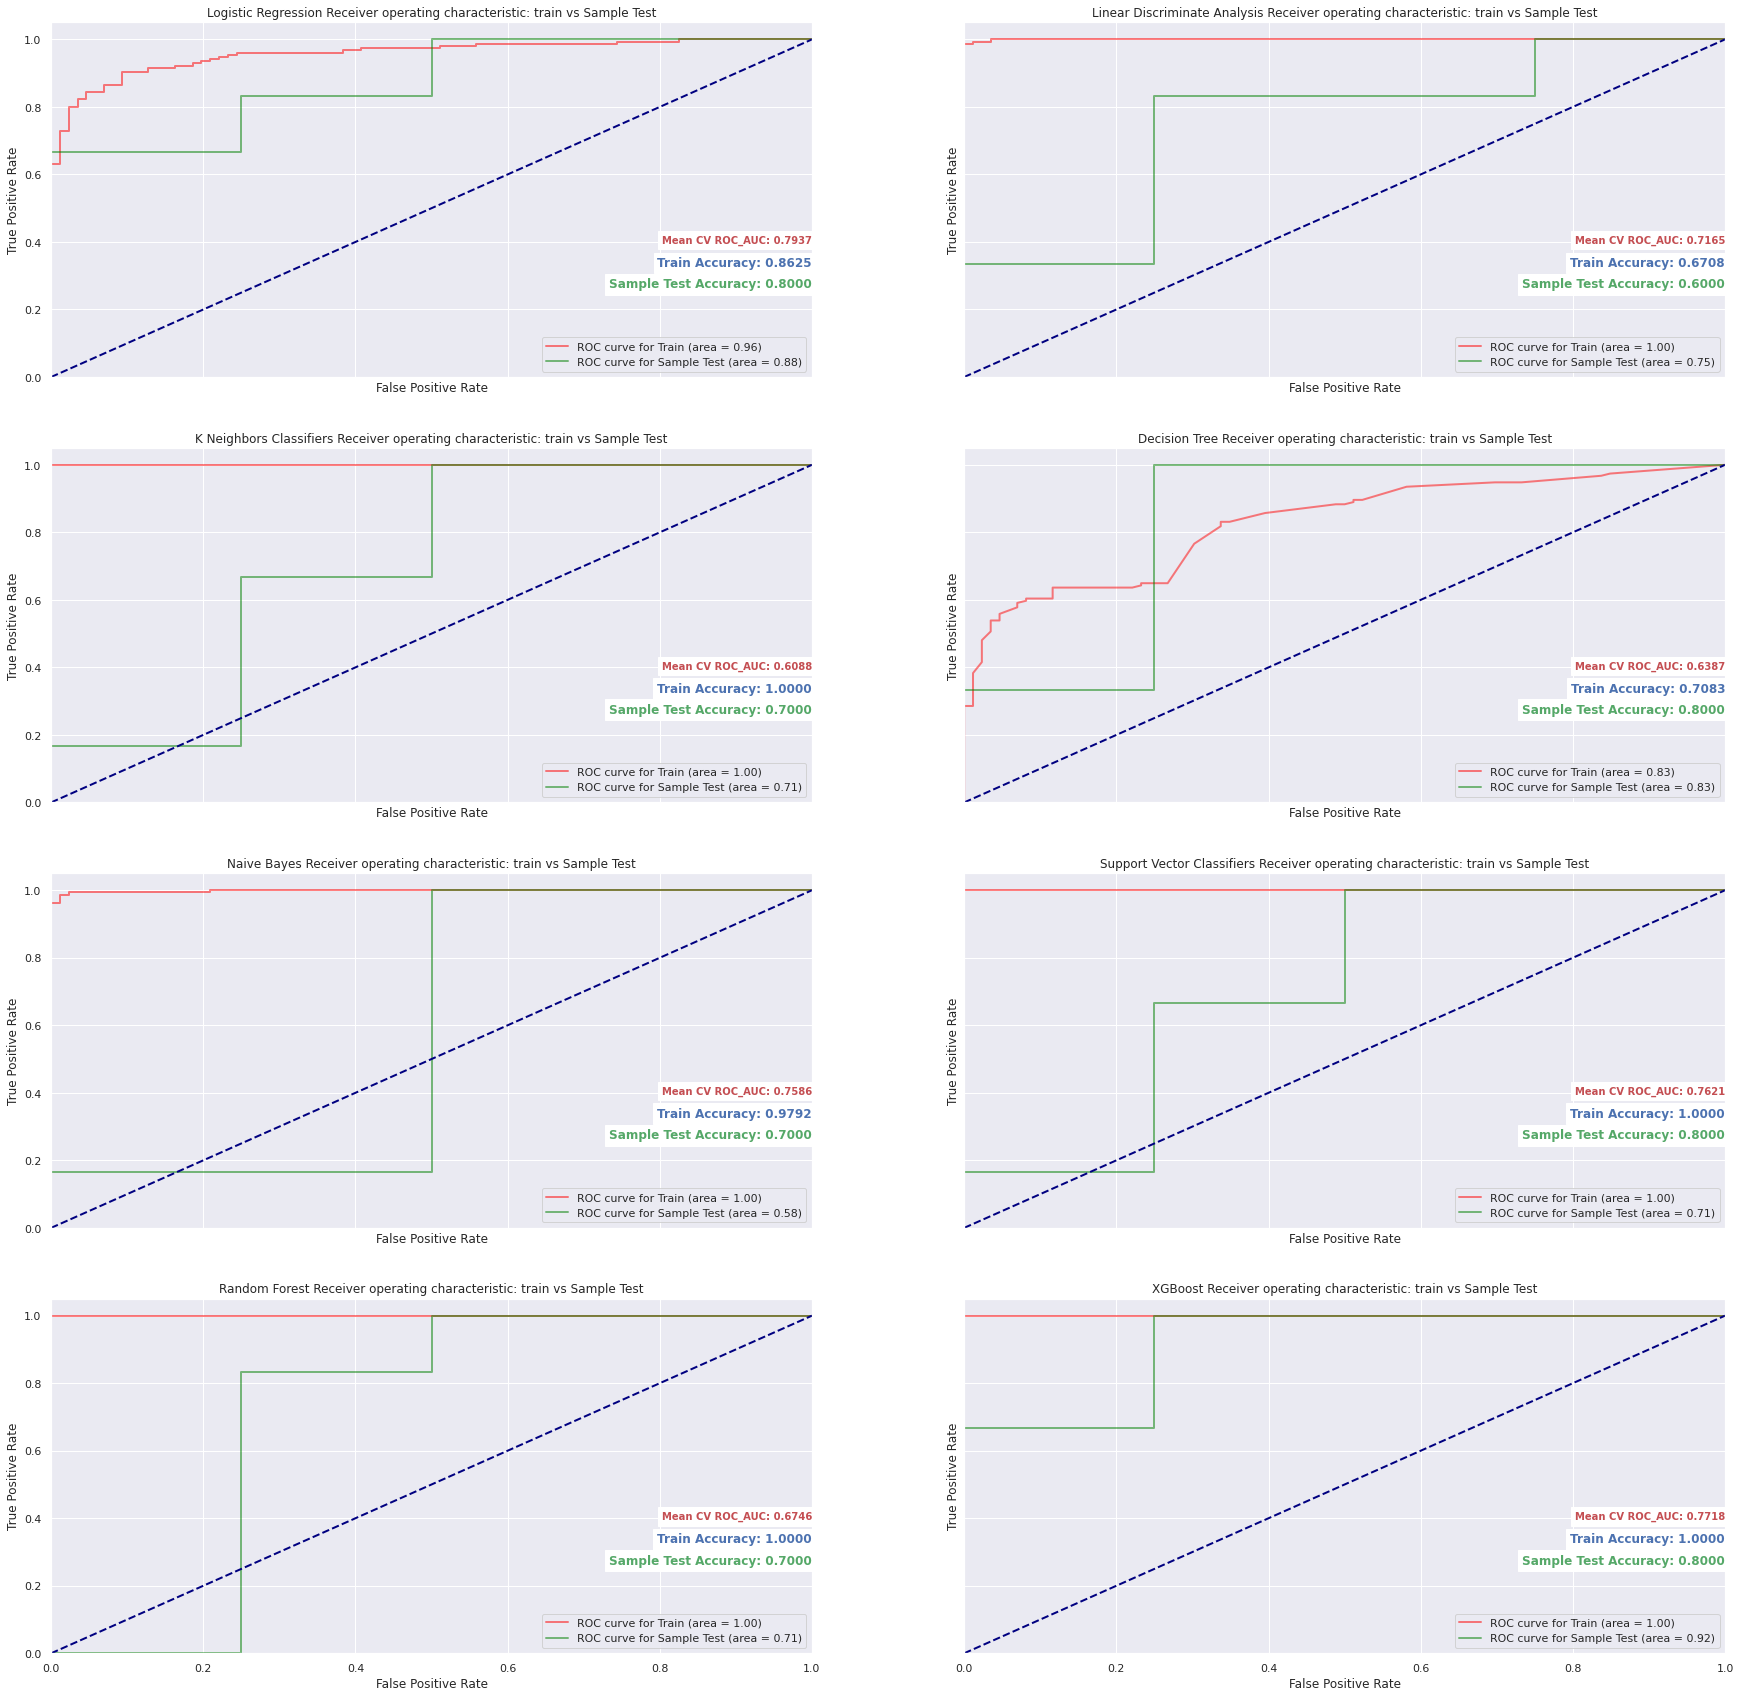

In [ ]:
baseline_best_model, BM_clfs = trainWithBestModelAndParams(X_train, X_test, y_train, y_test, 'Baseline', test, CV=5)

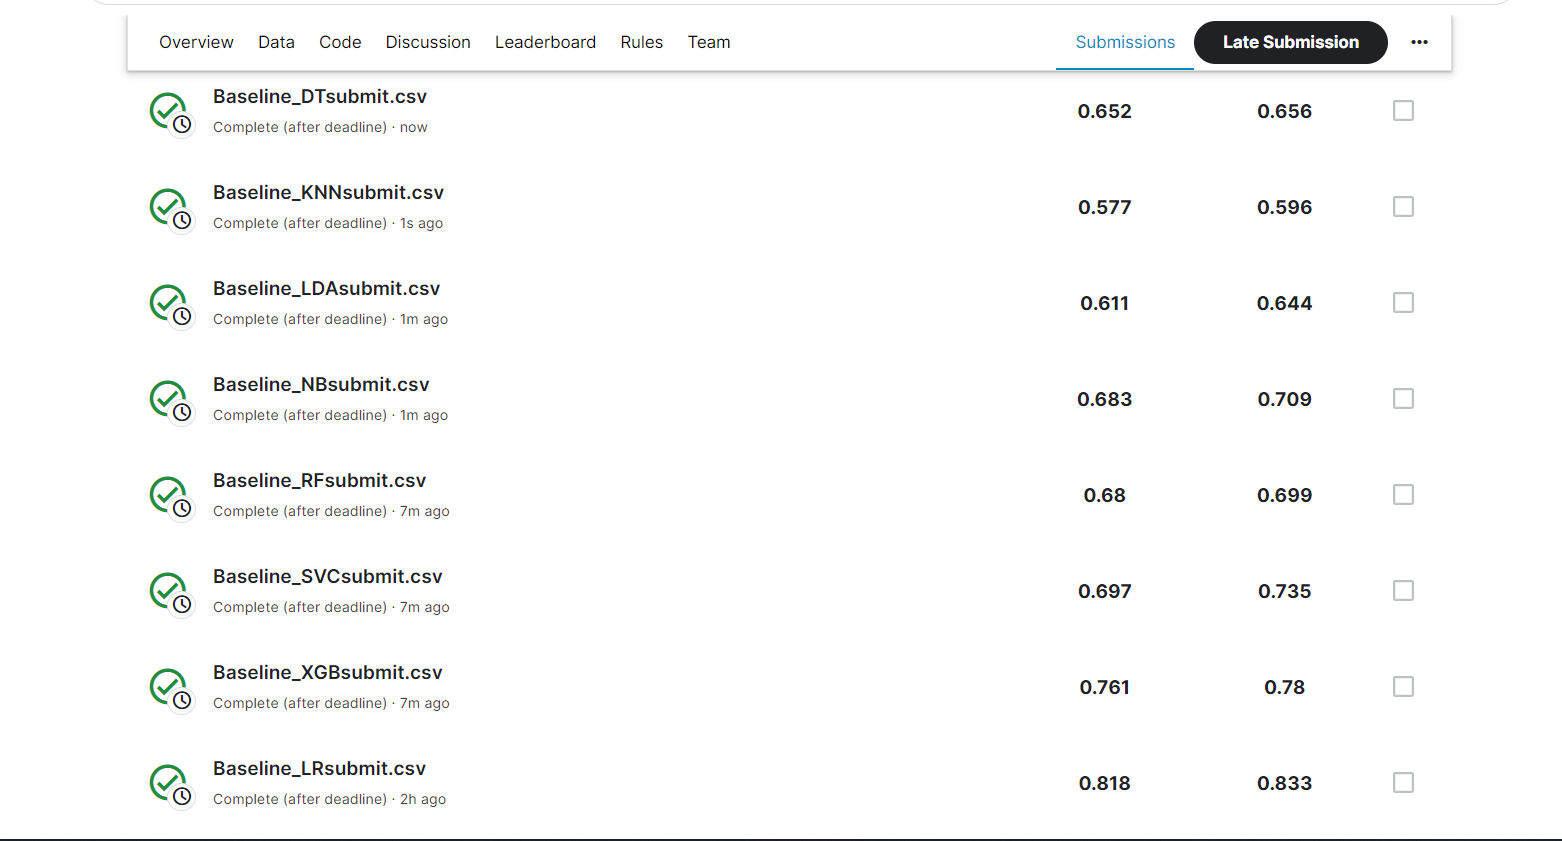

In [ ]:
Image('/content/drive/MyDrive/CasestudiesAAIC/self case study12/result/Baseline/submission.png')

# Baseline + Feature Engineering

In [9]:
def feature_enng(df):
    temp = df

    # Mean and Std FE
    df['mean'] = np.mean(temp, axis=1)
    df['std'] = np.std(temp, axis=1)

    # Trigometric FE
    sin_temp = np.sin(temp)
    cos_temp = np.cos(temp)
    tan_temp = np.tan(temp)
    df['mean_sin'] = np.mean(sin_temp, axis=1)
    df['mean_cos'] = np.mean(cos_temp, axis=1)
    df['mean_tan'] = np.mean(tan_temp, axis=1)

    # Hyperbolic FE
    sinh_temp = np.sinh(temp)
    cosh_temp = np.cosh(temp)
    tanh_temp = np.tanh(temp)
    df['mean_sinh'] = np.mean(sin_temp, axis=1)
    df['mean_cosh'] = np.mean(cos_temp, axis=1)
    df['mean_tanh'] = np.mean(tan_temp, axis=1)

    # Exponents FE
    exp_temp = np.exp(temp)
    expm1_temp = np.expm1(temp)
    exp2_temp = np.exp2(temp)
    df['mean_exp'] = np.mean(exp_temp, axis=1)
    df['mean_expm1'] = np.mean(expm1_temp, axis=1)
    df['mean_exp2'] = np.mean(exp2_temp, axis=1)

    # Polynomial FE
    # X**2
    df['mean_x2'] = np.mean(np.power(temp,2), axis=1)
    # X**3
    df['mean_x3'] = np.mean(np.power(temp,3), axis=1)
    # X**4
    df['mean_x4'] = np.mean(np.power(temp,4), axis=1)

    return df

In [10]:
df_train = pd.read_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CasestudiesAAIC/self case study12//test.csv')
df_train_fe=feature_enng(df_train.drop(['id','target'],axis=1))
df_test_fe=feature_enng(df_test.drop(['id'],axis=1))

In [21]:
X = df_train_fe
y = df_train['target']
test = df_test_fe
#stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42) 

In [ ]:
baseline_best_model_fe, BM_fe_clfs = trainWithBestModelAndParams(X_train, X_test, y_train, y_test, 'Baseline_fe', test, CV=5)

Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7937 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.7045 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6009 | {'weights': 'distance', 'n_neighbors': 6, 'n_jobs': -1, 'leaf_size': 2, 'algorithm': 'auto'}
Decision Tree                  | 0.6387 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7420 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7617 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest       

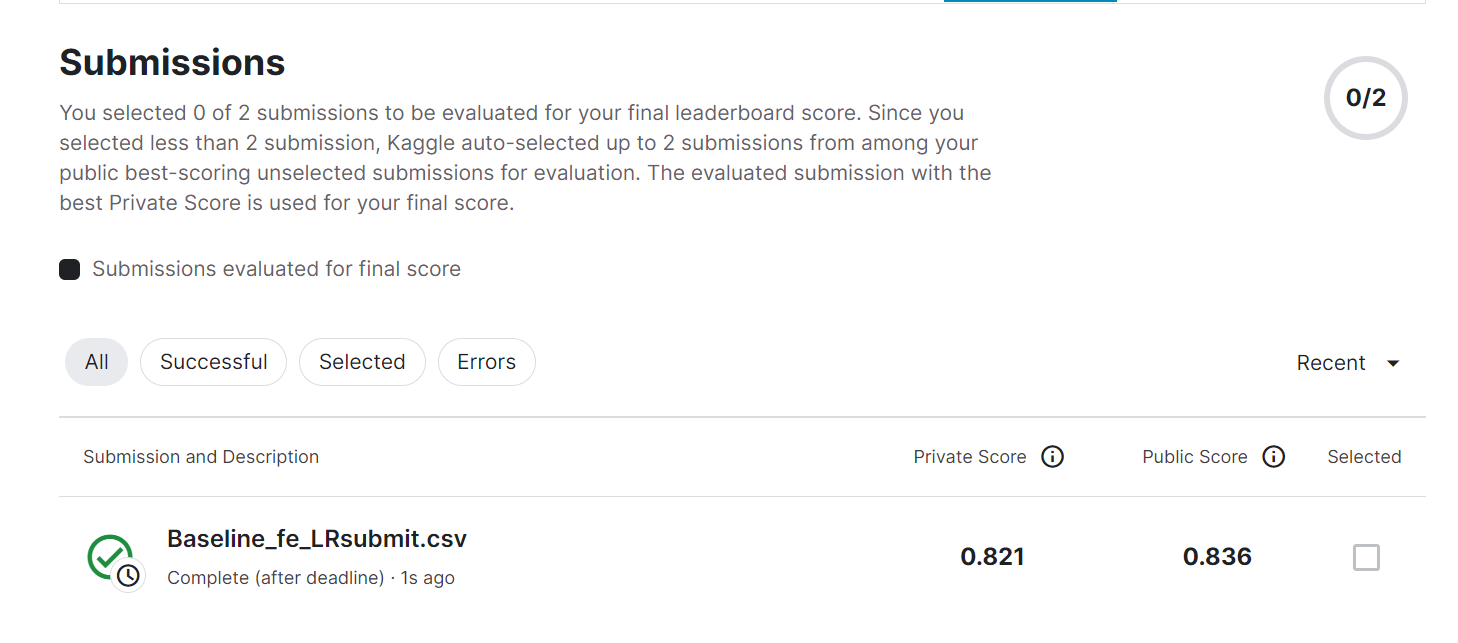

In [24]:
Image('/content/Baseline_FE.png')

# Random Sampling model(Preprocessing)

In [ ]:
#Synthetic Minority Oversampling Technique.SMOTE is an algorithm that performs data augmentation by creating synthetic data points based on the original data points. SMOTE can be seen as an advanced version of oversampling

##Oversampling

In [ ]:
smote = SMOTE()
Xo_train, yo_train = smote.fit_resample(X_train, y_train)
print(Xo_train.shape, yo_train.shape) # (308, 300) (308,)

(308, 300) (308,)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.9114 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.6999 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.5265 | {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Decision Tree                  | 0.6955 | {'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced'}
Naive Bayes                    | 0.8975 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.9224 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Fores

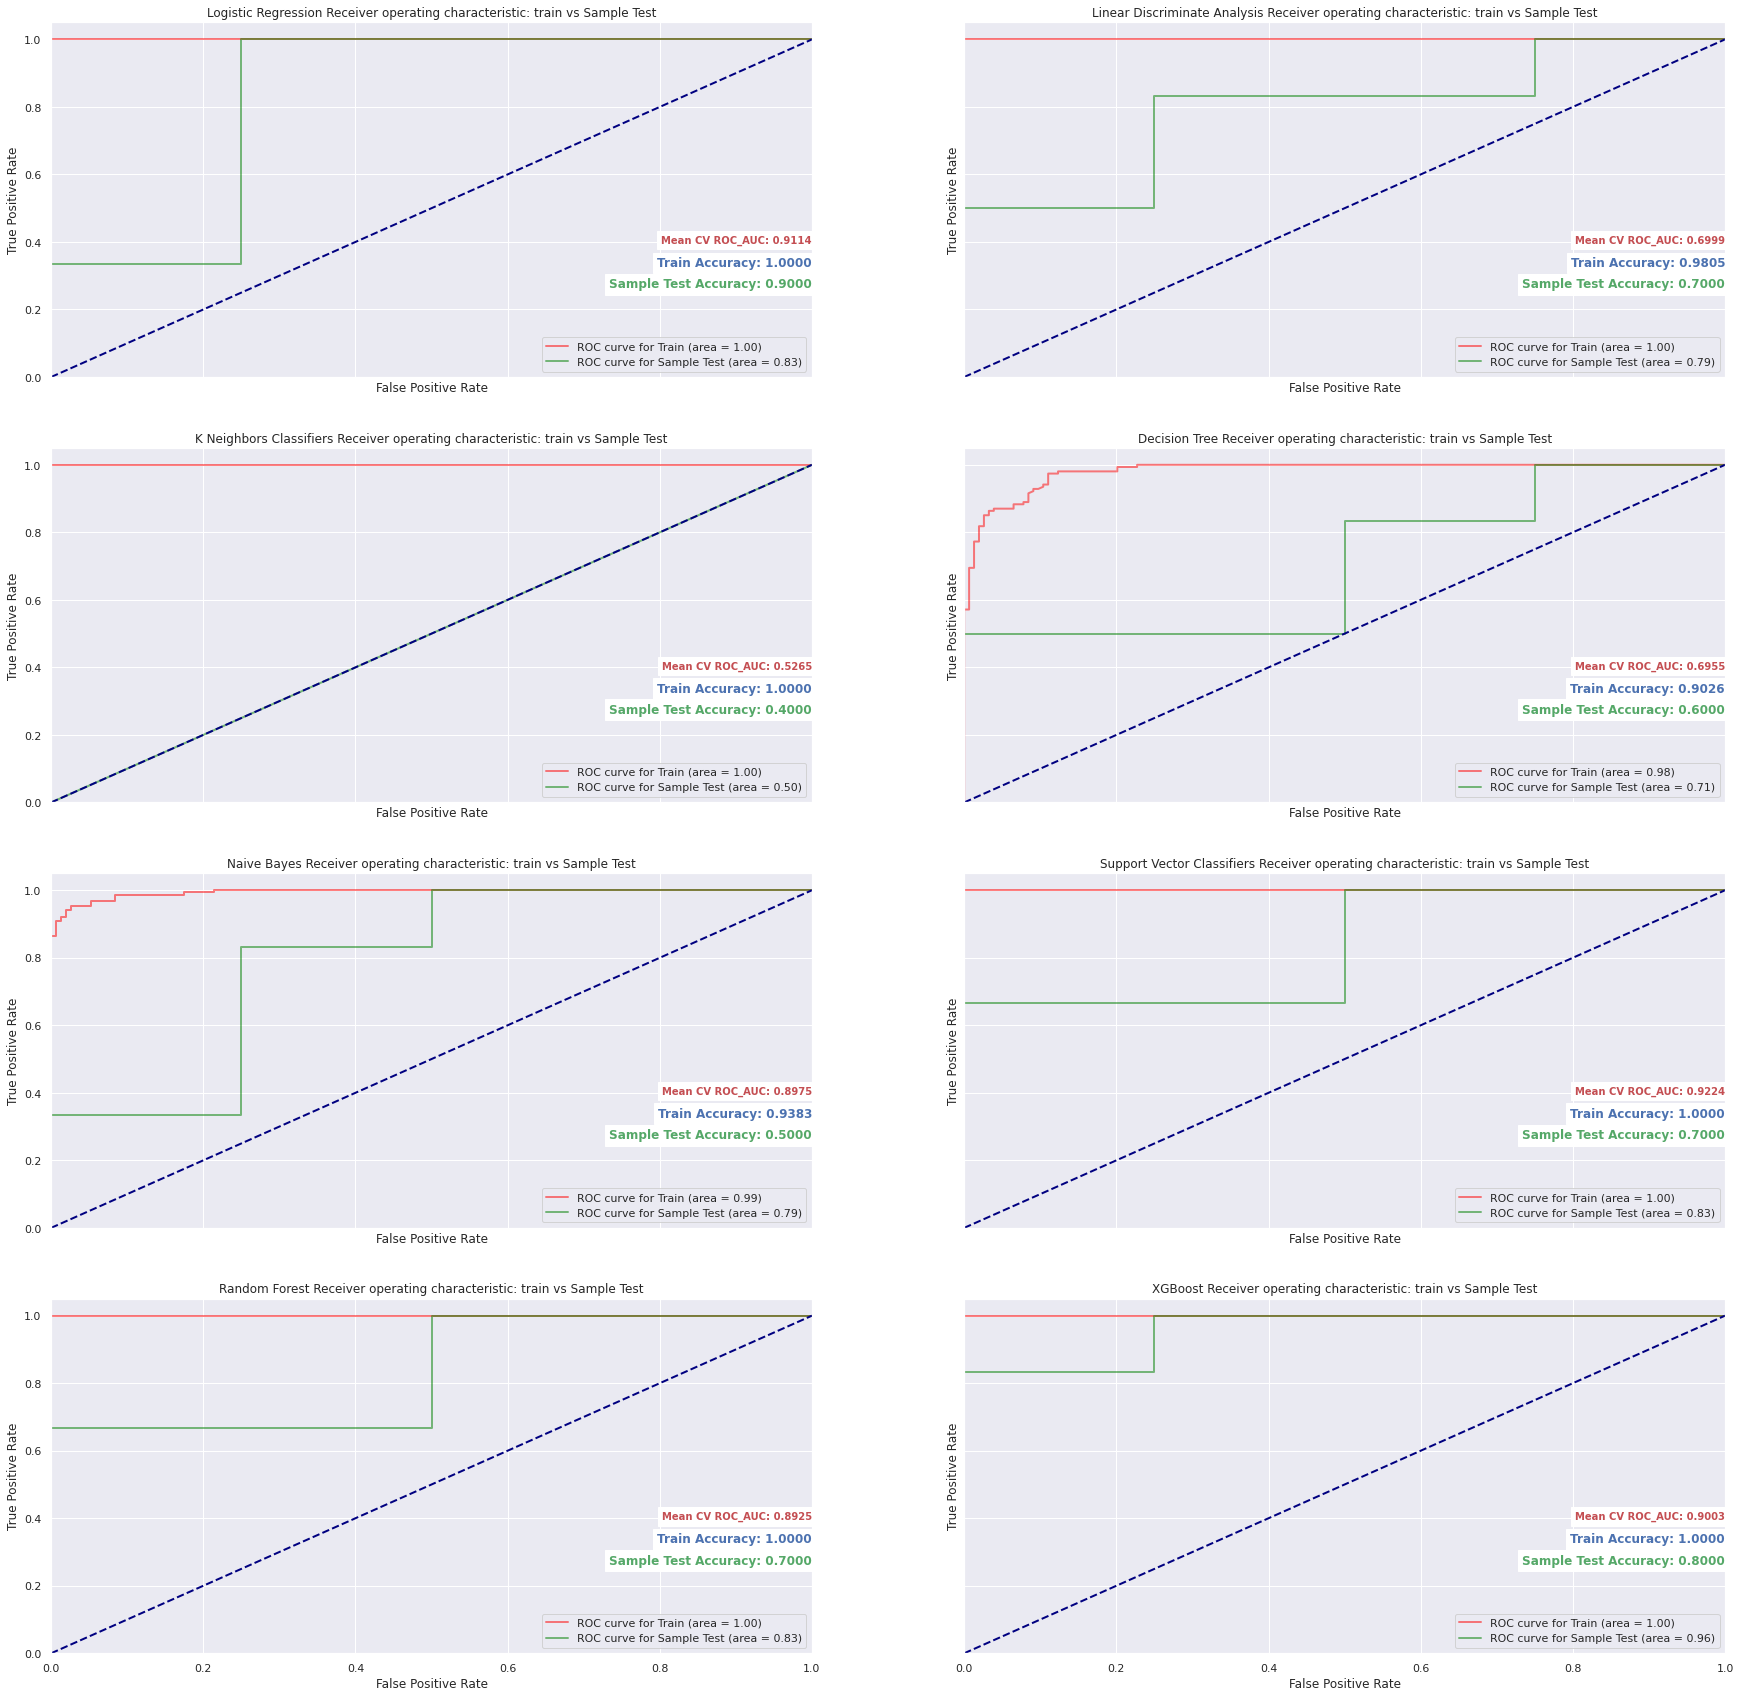

In [ ]:
overSample_best_model, OS_clfs = trainWithBestModelAndParams(Xo_train, X_test, yo_train, y_test, 'OverSample', test, CV=5)

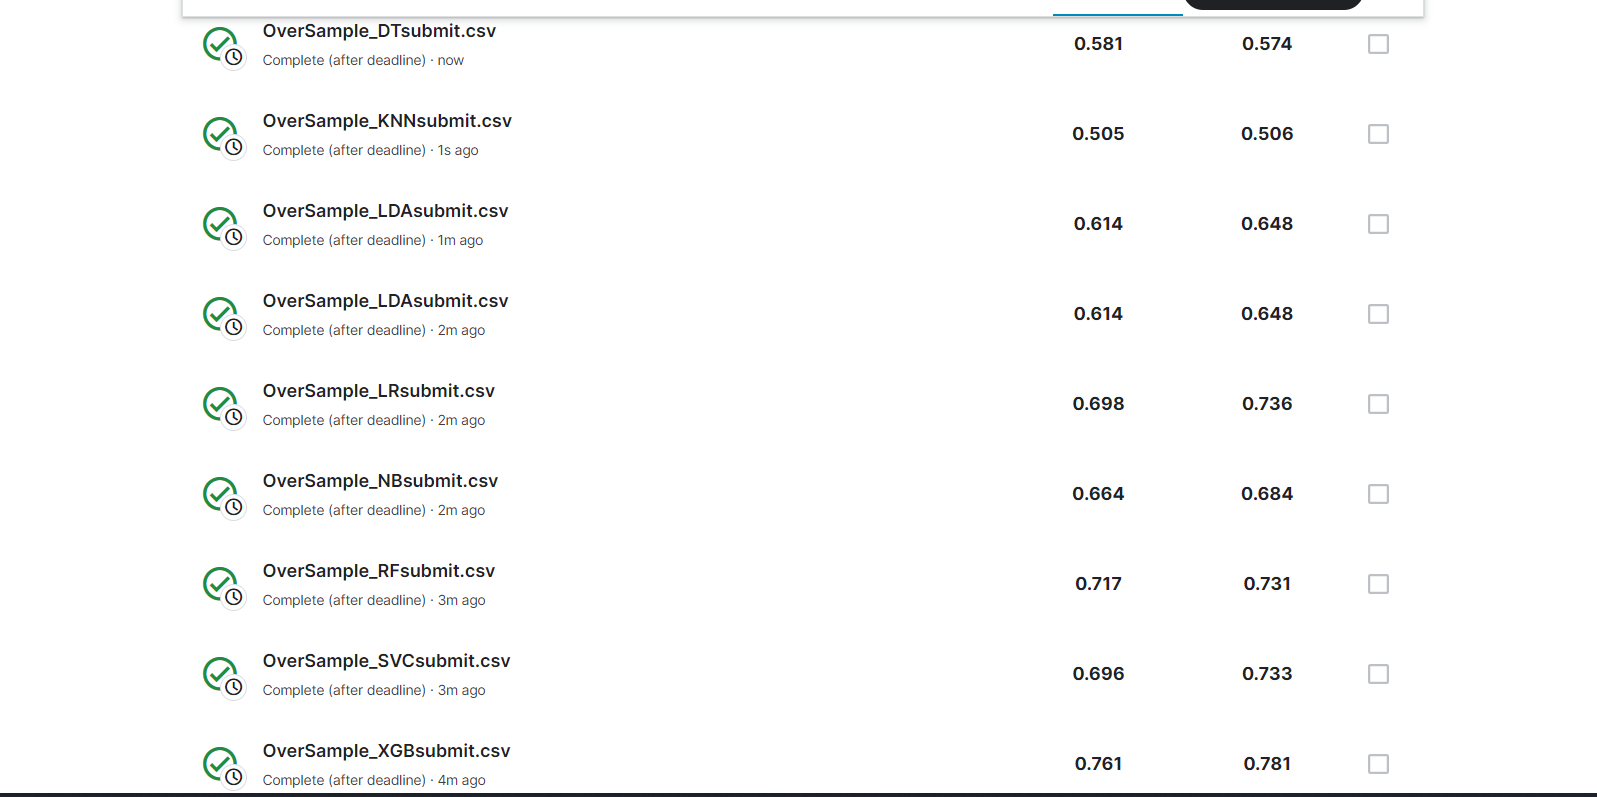

In [ ]:
Image('/content/submission_oversample.png')

##Under sampling

In [ ]:
smote = SMOTE(sampling_strategy=0.75)
Xo_train, yo_train = smote.fit_resample(X_train, y_train)
print(Xo_train.shape, yo_train.shape) 

under = RandomUnderSampler(sampling_strategy=1.0)
Xou_train, you_train = under.fit_resample(Xo_train, yo_train)
print(Xou_train.shape, you_train.shape) 

(269, 300) (269,)
(230, 300) (230,)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.8960 | {'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'intercept_scaling': 4, 'class_weight': 'balanced', 'C': 1}
Linear Discriminate Analysis   | 0.6242 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6253 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.6626 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.8692 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.8775 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest         

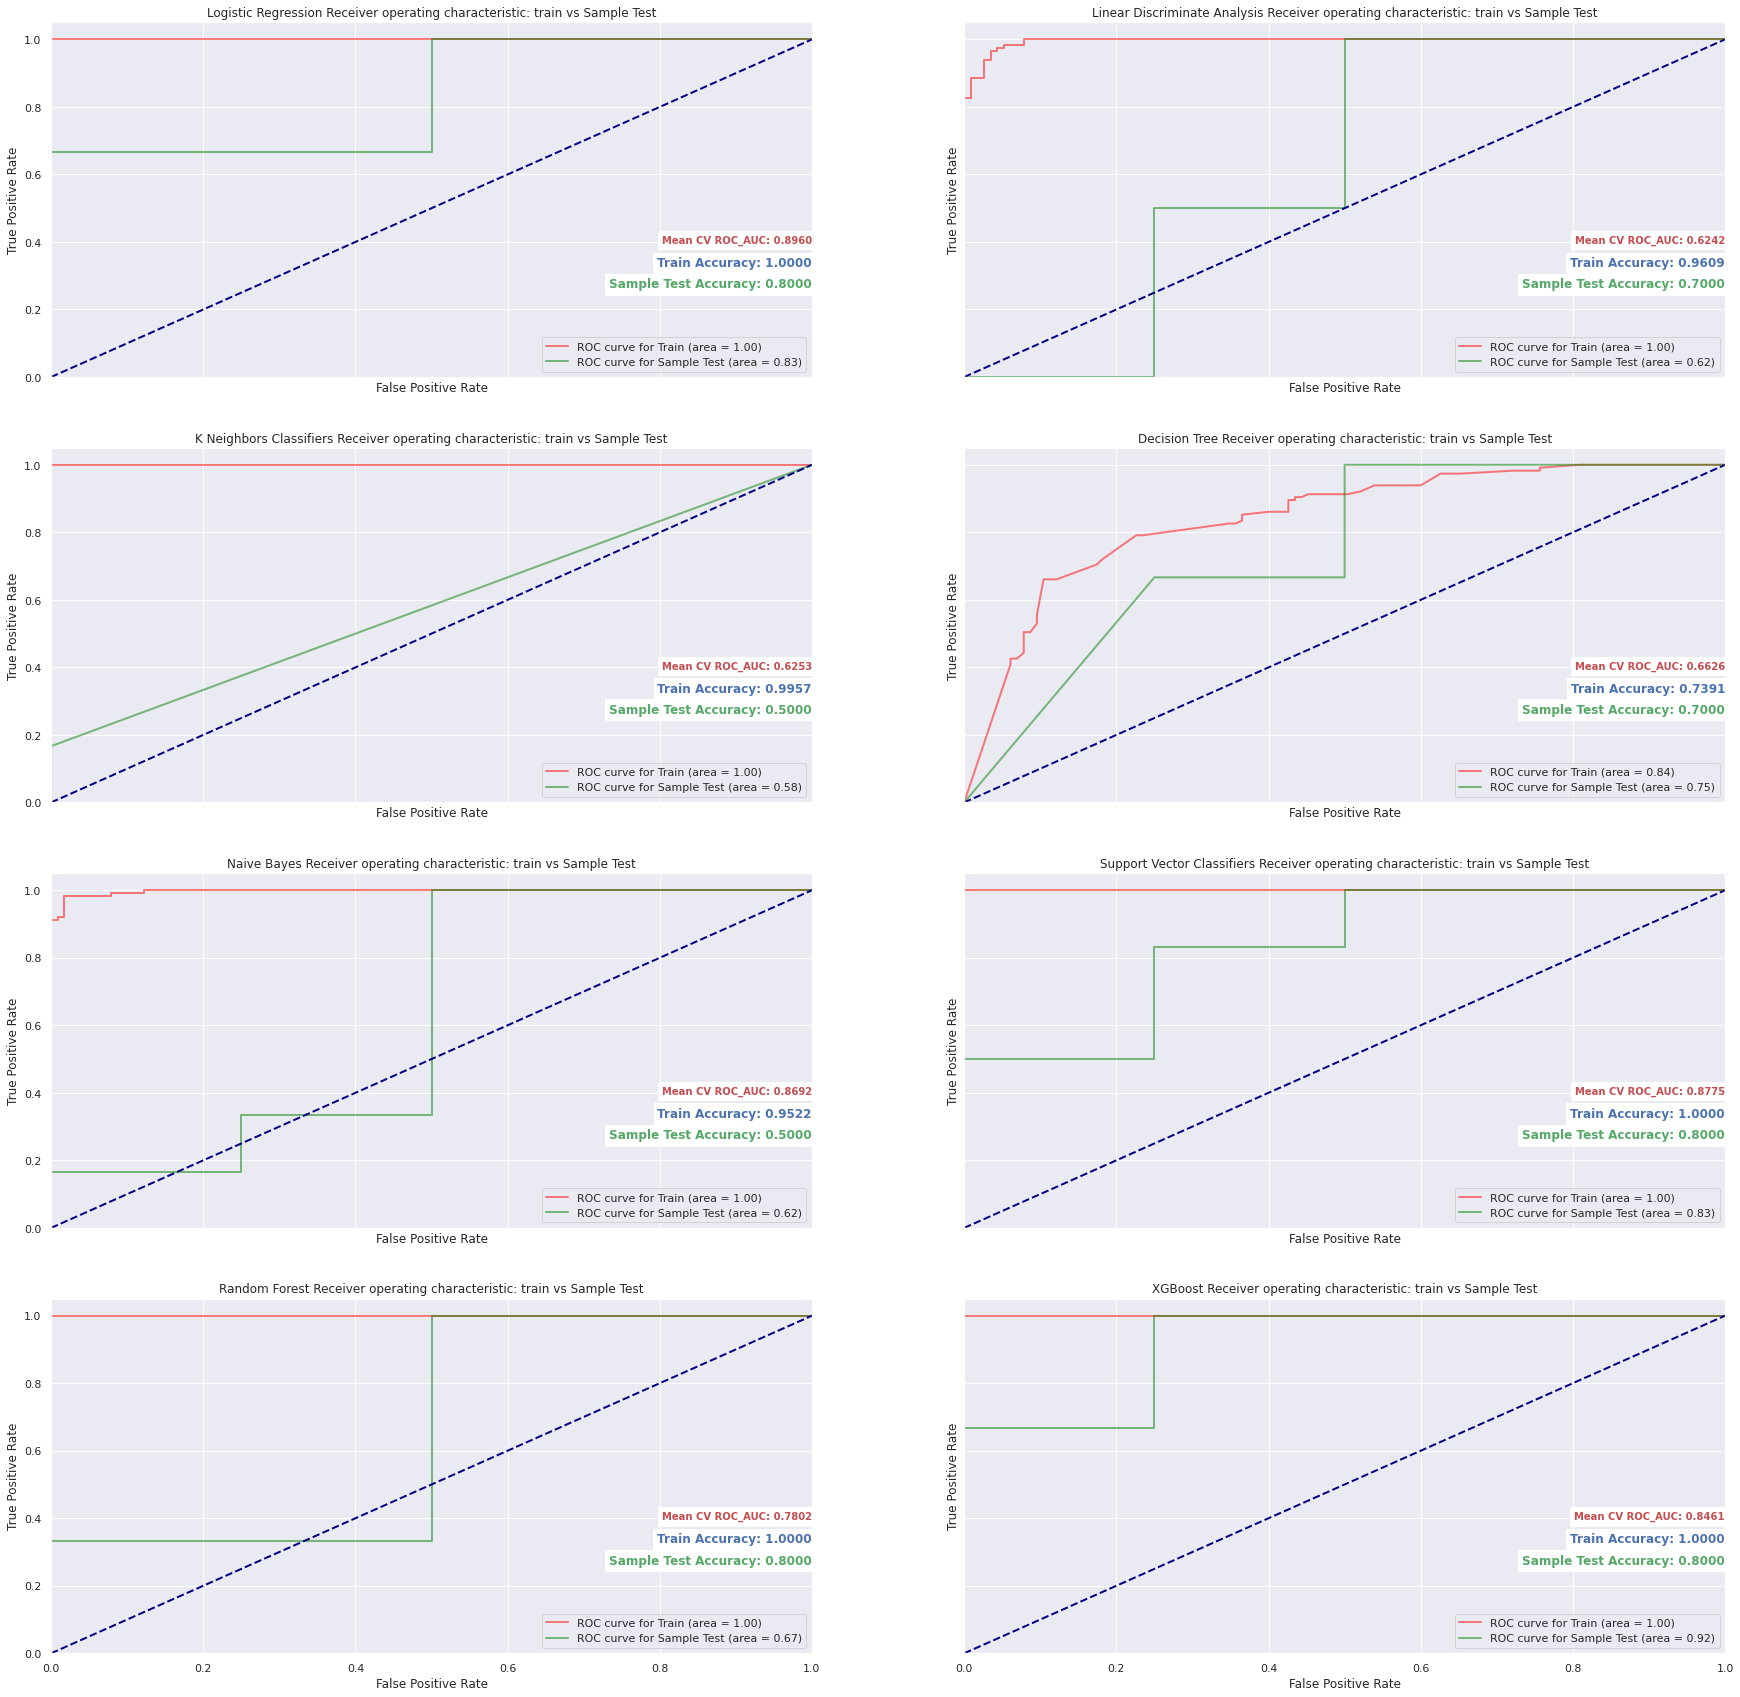

In [ ]:
overUnderSample_best_model, OUS_clfs = trainWithBestModelAndParams(Xou_train, X_test, you_train, y_test, 'OverUnderSample', test, CV=5)

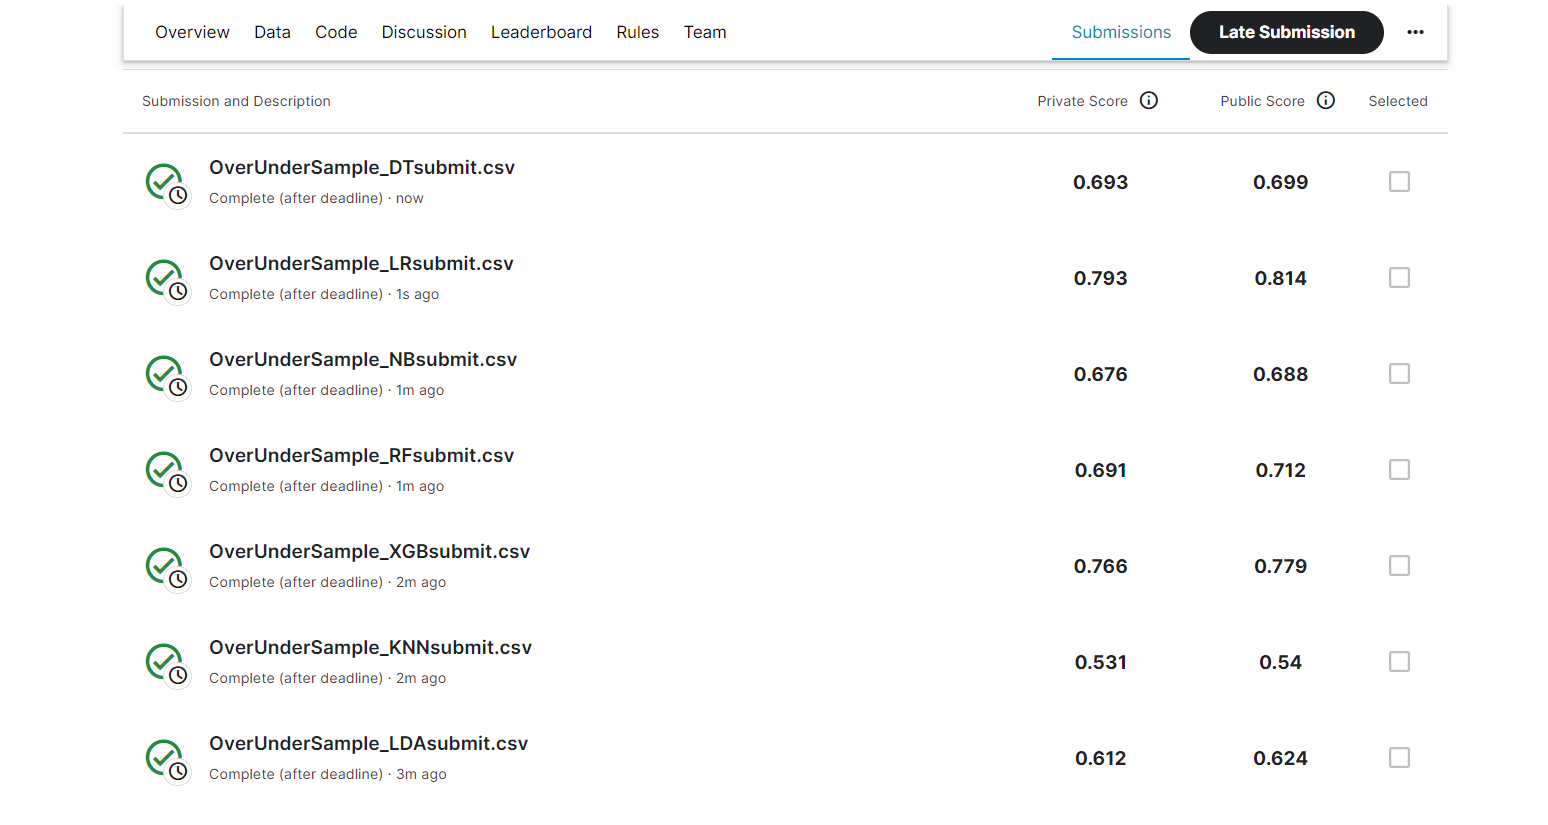

In [ ]:
Image('/content/undersampling_submission.png')

# Feature selection model

## Mutual Information

In [ ]:
select_k = 20
selection = SelectKBest(mutual_info_classif, k=select_k).fit(X_train, y_train)
print('Best {} selected Features are: {}'.format(select_k, list(X_train.columns[selection.get_support()])))

Best 20 selected Features are: ['2', '17', '18', '33', '36', '44', '80', '91', '92', '96', '98', '122', '130', '131', '165', '219', '231', '247', '289', '298']


In [ ]:
Xmi_train = selection.transform(X_train)
Xmi_test = selection.transform(X_test)
test_mi = selection.transform(test)
print(Xmi_train.shape, y_train.shape) #(240, 20) (240,)
print(Xmi_test.shape, y_test.shape) #(10, 20) (10,)
print(test_mi.shape)

(240, 20) (240,)
(10, 20) (10,)
(19750, 20)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7398 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'intercept_scaling': 2, 'class_weight': 'balanced', 'C': 0.001}
Linear Discriminate Analysis   | 0.7082 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6725 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.6483 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7414 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7418 | {'probability': True, 'kernel': 'rbf', 'gamma': 0.0001, 'class_weight': 'balanced', 'C': 200}
Random Forest    

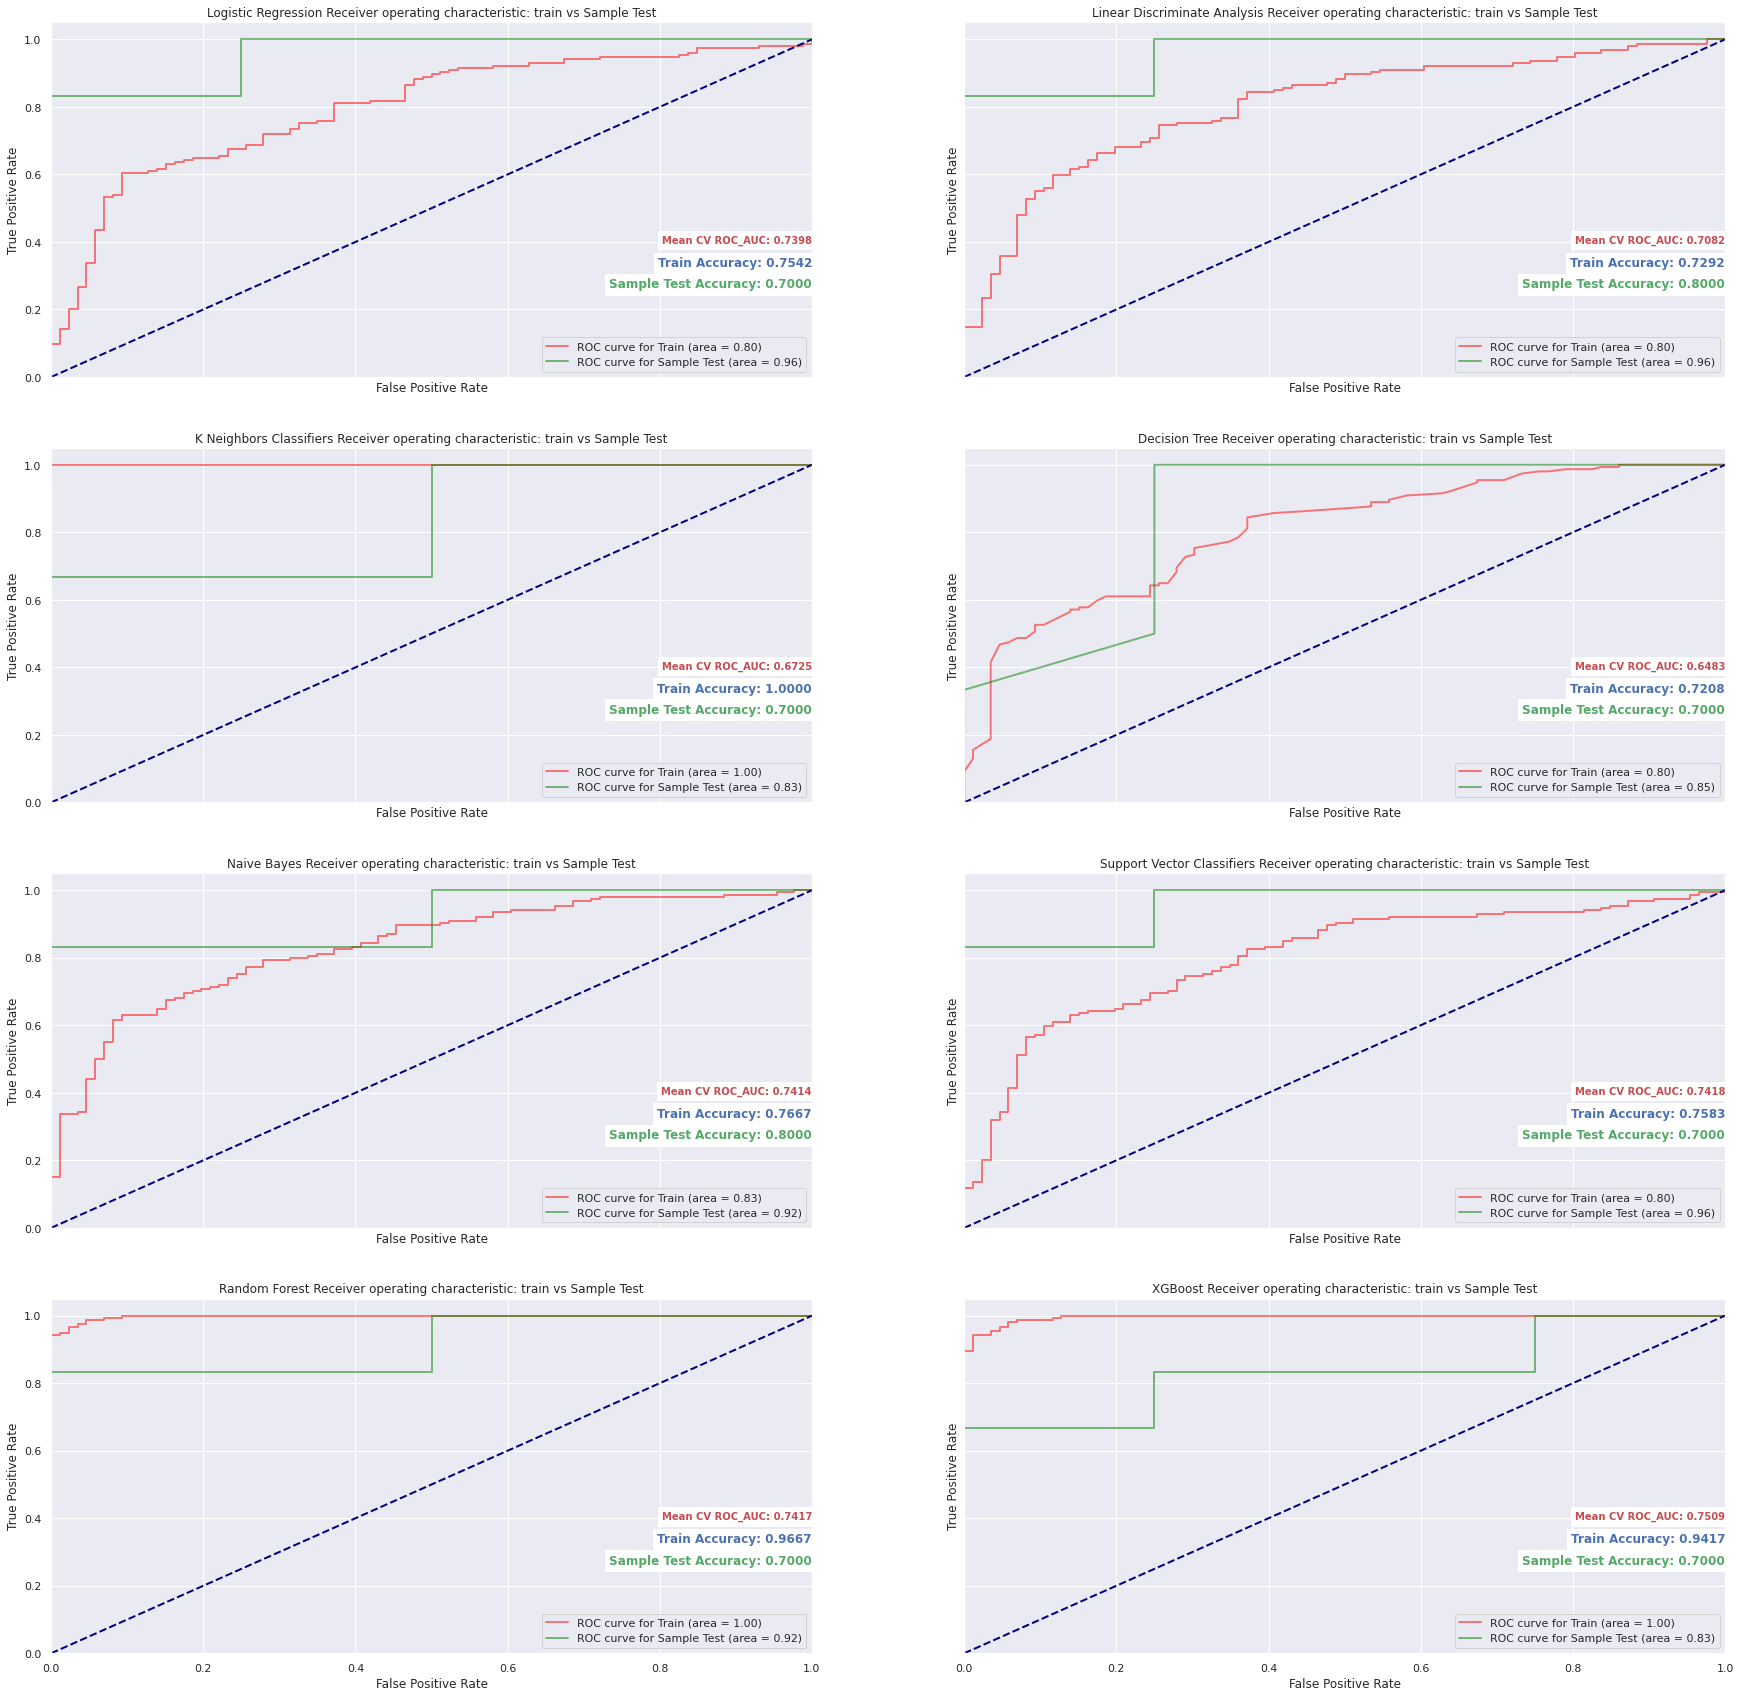

In [ ]:
MI_best_model, MI_clfs = trainWithBestModelAndParams(Xmi_train, Xmi_test, y_train, y_test, 'MI', test_mi, CV=5)

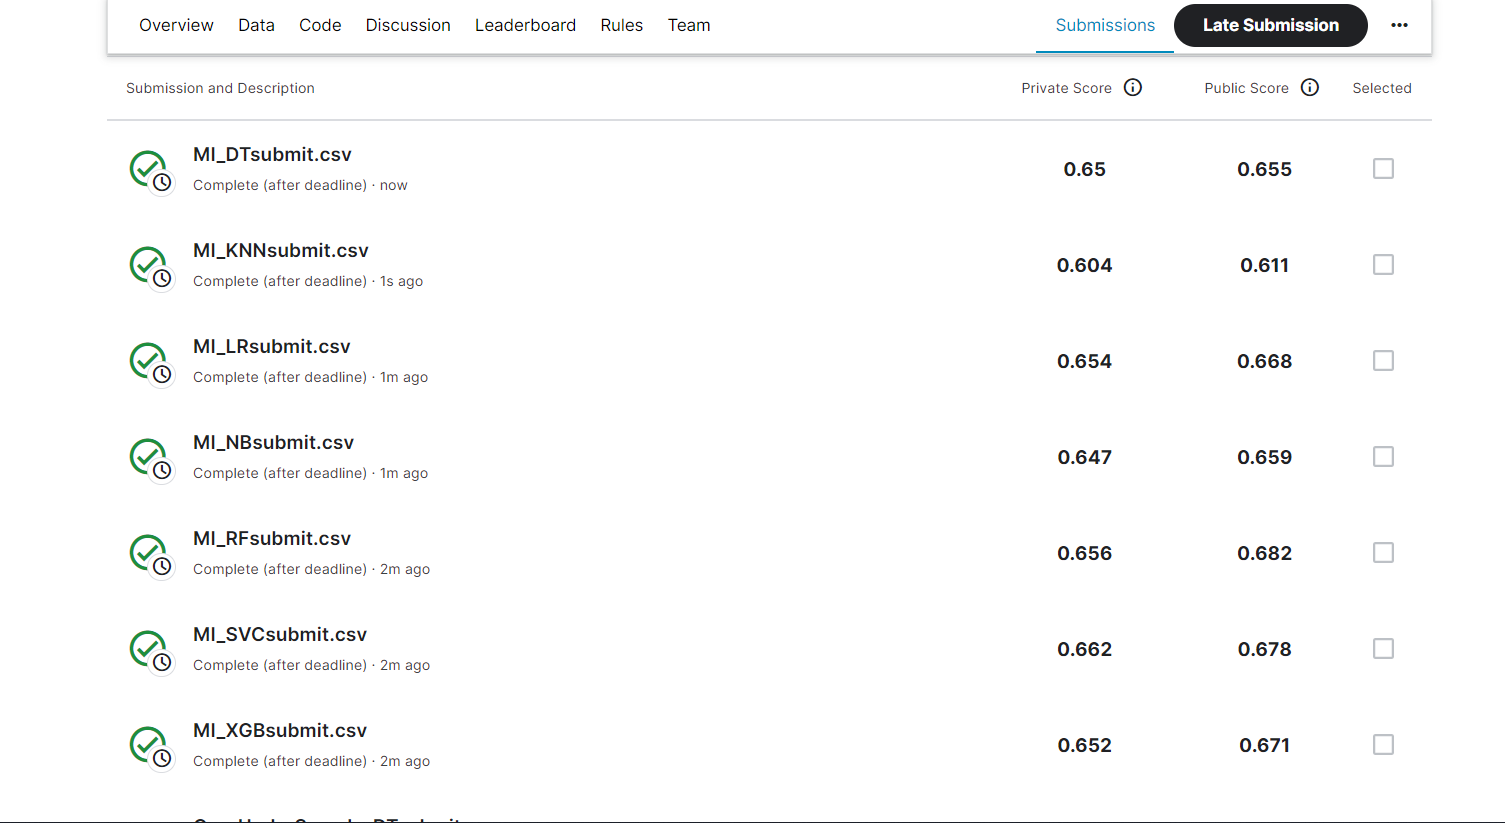

In [ ]:
Image('/content/mi_submission.png')

##Recursive Feature Elimination (RFE)

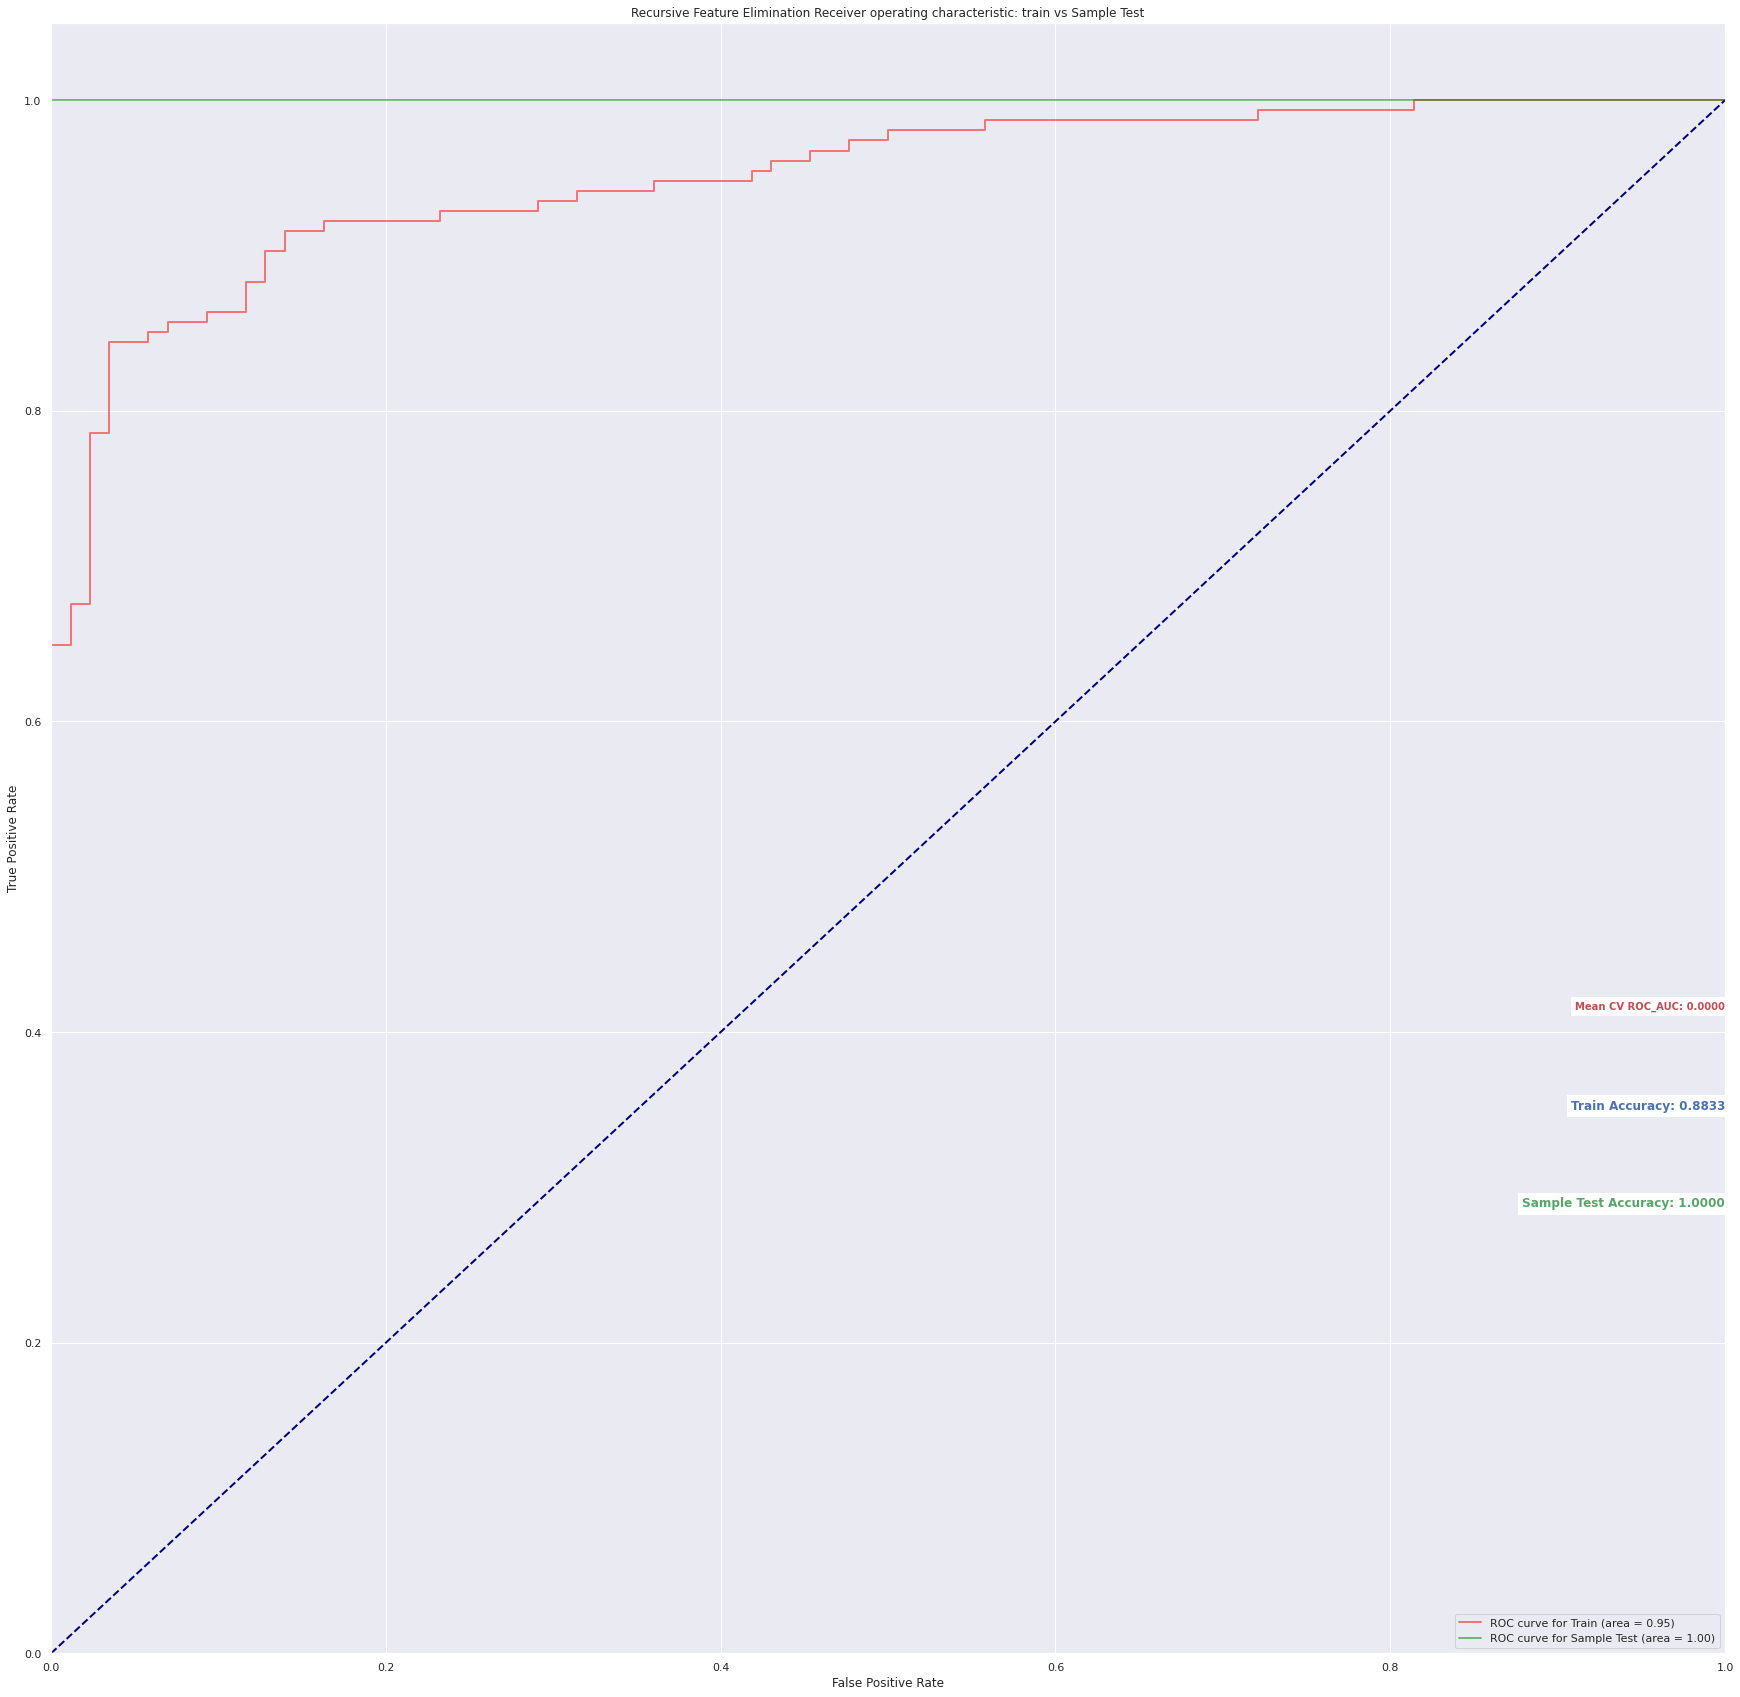

In [ ]:
Modeltype = 'RFE'
Modelname = baseline_best_model[4]

#Scaling
scl = StandardScaler()
Xrfe = scl.fit_transform(X)
Xrfe_train, Xrfe_test, test_rfe = scale(X_train, X_test, test)

#Fitting to baseline model
clf = baseline_best_model[3]
clf.fit(Xrfe,y)

#Feature Selection using RFE
selector = RFE(clf, 25, step=1)
selector.fit(Xrfe,y)

#plot ROC curve
_, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(30,10)})
plot_roc(y_train, selector.predict_proba(Xrfe_train), y_test, selector.predict_proba(Xrfe_test), ax,'Recursive Feature Elimination', \
         0.00, selector.score(Xrfe_train,y_train), selector.score(Xrfe_test, y_test), n_classes=2)

#Saving Model into Drive
#filename = 'BestModel.sav'
#joblib.dump(selector, filename)
save_model(selector, Modeltype, Modelname)
pred = selector.predict_proba(test_rfe)[:,1]

#Saving prediction into disk
save_test_result(pred, Modeltype, Modelname)

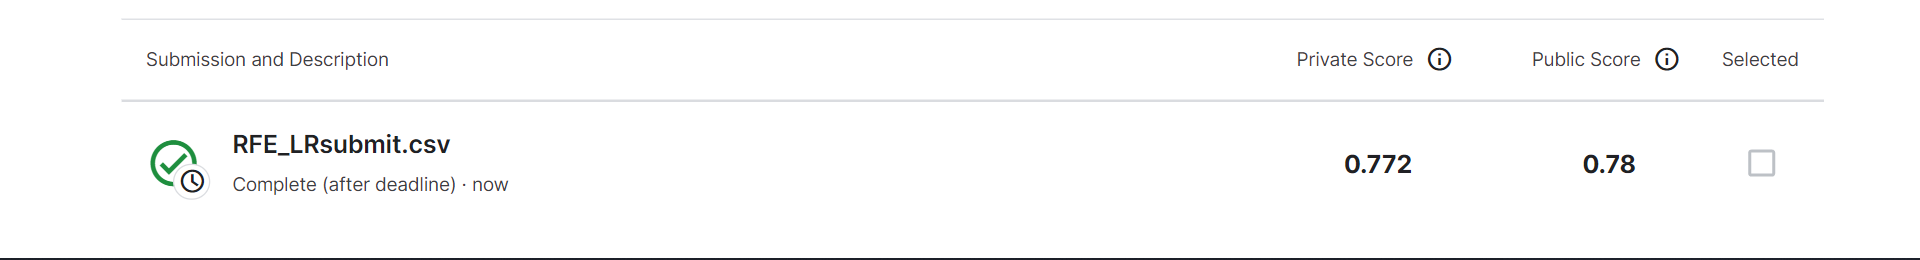

In [ ]:
Image('/content/rfe_submission.png')

##Embedding models

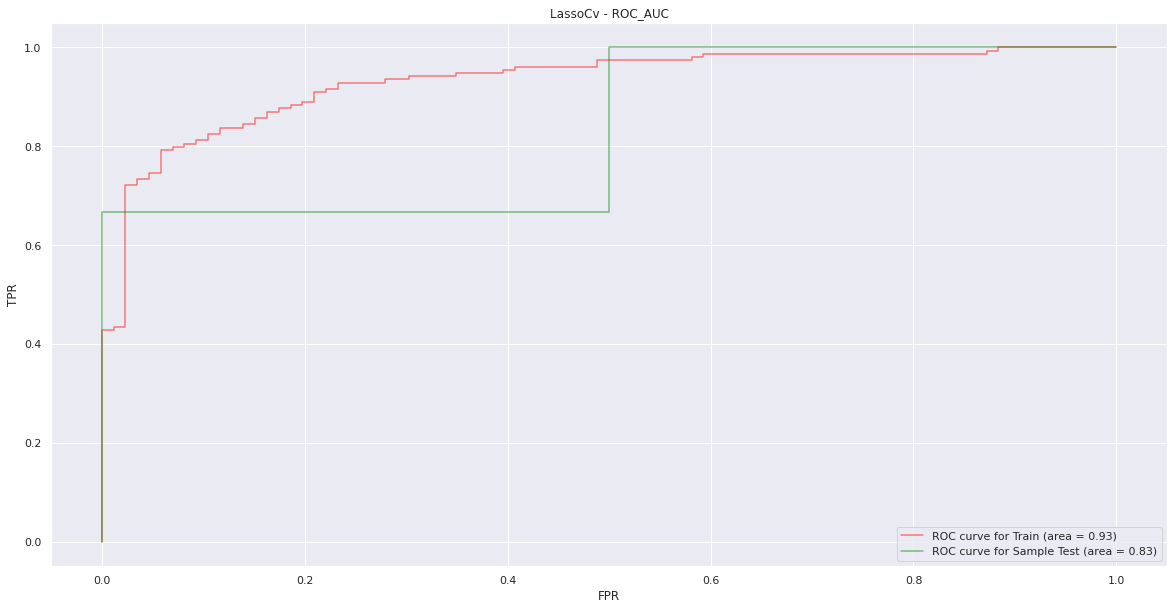

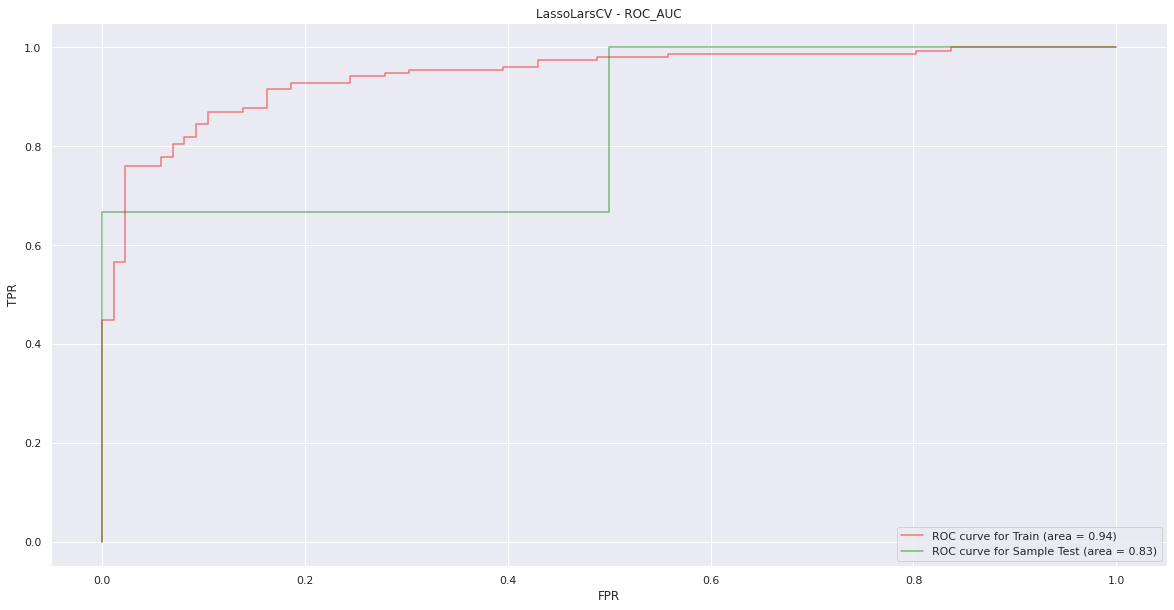

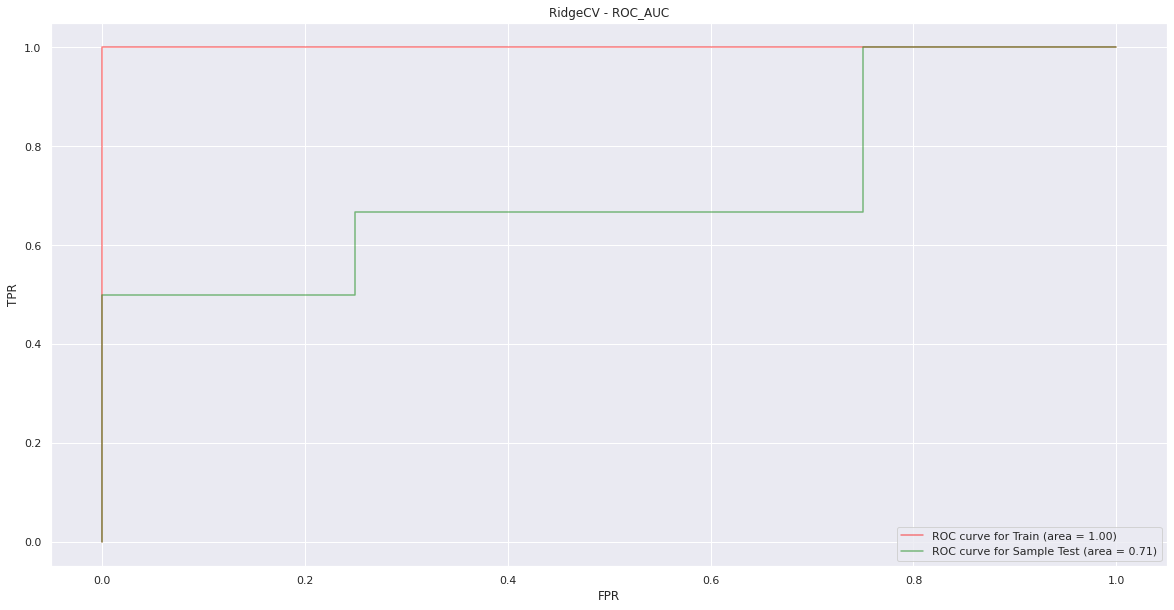

In [ ]:
embd_models =  [
    ('LassoCv' , LassoCV(alphas =  [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], n_jobs=-1) ),
    ('LassoLarsCV', LassoLarsCV(n_jobs=-1) ),
    ('RidgeCV', RidgeCV() )
]

Modeltype = 'EmbeddedF'

for model in embd_models:
    clf = model[1]
    clf.fit(X_train, y_train)
    pred = clf.predict(test)

    #Saving prediction into disk
    save_model(clf, Modeltype, model[0])
    save_test_result(pred, Modeltype, model[0])

    #plot ROC_AUC
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    tr_fpr, tr_tpr, _ = roc_curve(y_train,  y_train_pred)
    te_fpr, te_tpr, _ = roc_curve(y_test,  y_test_pred)

    tr_auc = roc_auc_score(y_train, y_train_pred)
    te_auc = roc_auc_score(y_test, y_test_pred)
    sns.set(rc={'figure.figsize':(20,10)})
    plt.plot(tr_fpr,tr_tpr,label='ROC curve for Train (area = %0.2f)' % tr_auc, alpha=0.5, color='red')
    plt.plot(te_fpr,te_tpr,label='ROC curve for Sample Test (area = %0.2f)' % te_auc, alpha=0.5, color='green')
    plt.title(model[0]+' - ROC_AUC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc=4)
    plt.show()

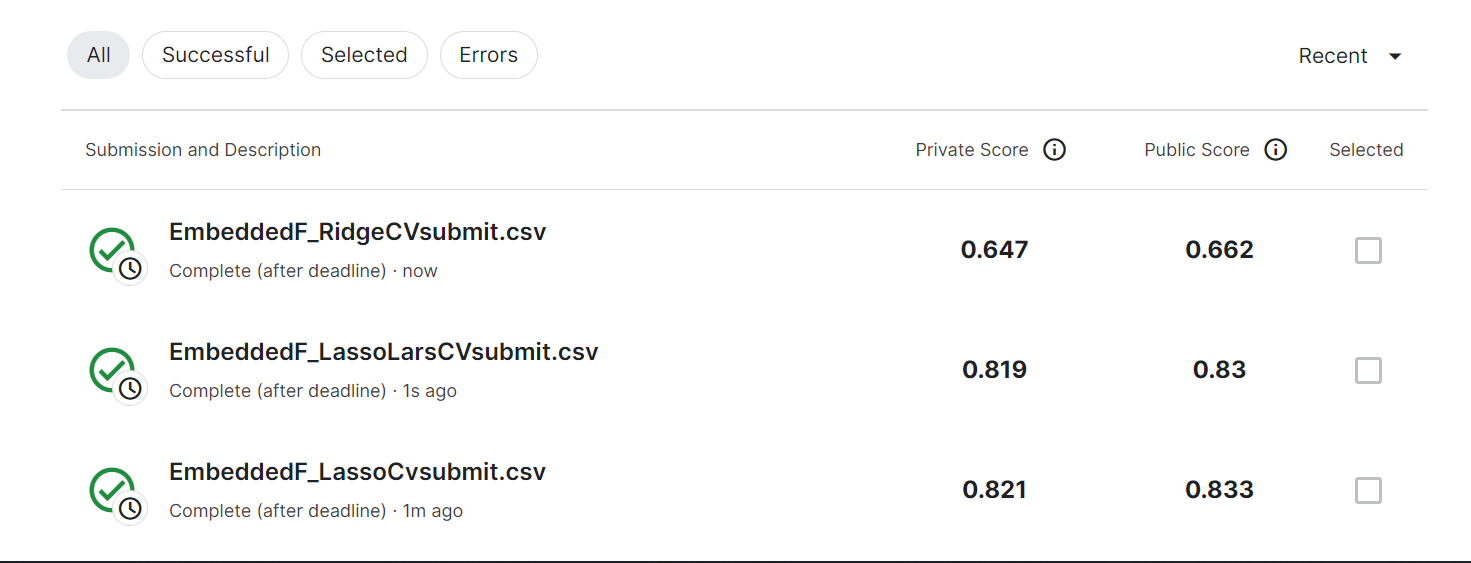

In [ ]:
Image('/content/embedded_submission.png')

## Result table

In [15]:
x = PrettyTable()
x.field_names = ['Rank','Model Name', 'Classifiers Used', 'Kaggle public score', 'Kaggle private score']
x.add_row([1,'Baseline+Feature_engineering', 'Logistic Regression', '0.836', '0.821'])
x.add_row([2,'Embedded', 'LassoCV', '0.833', '0.821'])
x.add_row([3,'Embedded', 'LassoLarsCv', '0.830','0.819'])
x.add_row([4,'Baseline', 'Logistic Regression', '0.833', '0.818'])
#x.add_row([5,'Engineered Features', 'Logistic Regression','0.797','0.762'])
x.add_row([6,'RFE', 'Logistic Regression','0.78', '0.772'])
x.add_row([7,'Over Sample','XGBoost','0.781','0.761'])
#x.add_row([8,'SFFS','Naive Bayes','0.715','0.712'])
#x.add_row([9,'SFS','Random Forest','0.720','0.710'])
x.add_row([10,'Over Under Sample','Logistic Regression','0.814','0.793'])
x.add_row([11,'Mutual Information','Suport Vector Classifiers','0.678','0.662'])
print(x)

+------+------------------------------+---------------------------+---------------------+----------------------+
| Rank |          Model Name          |      Classifiers Used     | Kaggle public score | Kaggle private score |
+------+------------------------------+---------------------------+---------------------+----------------------+
|  1   | Baseline+Feature_engineering |    Logistic Regression    |        0.836        |        0.821         |
|  2   |           Embedded           |          LassoCV          |        0.833        |        0.821         |
|  3   |           Embedded           |        LassoLarsCv        |        0.830        |        0.819         |
|  4   |           Baseline           |    Logistic Regression    |        0.833        |        0.818         |
|  6   |             RFE              |    Logistic Regression    |         0.78        |        0.772         |
|  7   |         Over Sample          |          XGBoost          |        0.781        |       

#Summary

We have tried different classification models and then performed calibaration for the given dataset. The classification models used are :
1. Logistic Regression (linear)
2. Linear Discriminate Analysis(linear)
3. K Neighbors Classifiers (non-linear)
4. Decision Tree (non-linear)
5. Naive Bayes (non-linear)
6. Support Vector Classifiers (non-linear)
7. Random Forest (non-linear)
8. XGBoost (non-linear)

We have tried different approaches like balancing data, featureengieering, feature seletion etc .They are: 
* Baseline Model: In this approach we have just performed scaling and trained the standard models mentioned above. logistic regression gave us the best results comparatively (kaggle score - 0.818) which is a good score.
* Baseline Model +FE: In this approach we have just performed scaling and trained the standard models using original data along with new features which we have added. logistic regression gave us the best results comparatively (kaggle score - 0.821) which is a good score.
* Over Sample Model: In this approach, we first performed upsampling on the minority class using SMOTE algorithm to balance dataset then train with all the classifiers and got good results with XGBoost algorithm with a score of 0.761 (private score) which is less than the base model. As we have seen in EDA the model is not very higly imbalanced may be that is why the results didnt improve much. Lets check if undersampling helps .

* Over Under Sample Model: In this approach, applied both upsample and downsample to balance the dataset then train with all the classifiers and got the best score 0.793 (private score) by Logistic regression. This score proves that both upsampling and downsampling didnt work.

* Mutual Information Model: In this approach, mutual information which is a filter-based feature selection method has been applied to select only the best features and then train with all the classifiers. SVC algorithm gave a good score of 0.662 (private score). From this score, it can easily be concluded that this is not the best feature selection method for this problem.

* Recursive Feature Elimination(RFE) Model: In this model, RFE, a wrapper based feature selection method has been applied, used best baseline classifiers as an estimator to the RFE method, and got a result 0.772(private score).

* Embedded Model: In this model, the embedded method of feature selection has been applied and used 3 different embedded algorithms that are LassoCv, LassoLarsCV, and RidgeCV and got very score 0.821 result by LassoCV algorithm. This method gave us the best result.
